# Apple Stock Analysis (ARIMA)

- [x] Test for stationarity
- [x] Test for ACF and PACF
- [x] ARIMA

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import warnings

%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
apple = web.DataReader('AAPL', 'yahoo', start='2012-01-01', end='2021-09-30')
apple = apple.reset_index()
apple.tail(3)

,Date,High,Low,Open,Close,Volume,Adj Close
2450,2021-09-28,144.750000,141.690002,143.250000,141.910004,108972300.0,141.910004
2451,2021-09-29,144.449997,142.029999,142.470001,142.830002,74602000.0,142.830002
2452,2021-09-30,144.380005,141.279999,143.660004,141.500000,88934200.0,141.500000



## Testing for stationarity

In [4]:
ADF = adfuller(apple['Adj Close'], autolag='AIC')
print(f'\nADFuller Statistic: {ADF[0]}')
print(f'P-Value is: {ADF[1]}')

for key, value in ADF[4].items():
    print('\nCritical Value at:')
    print(f' {key}, {value}')


ADFuller Statistic: 1.8139469131761483
P-Value is: 0.9983762811005842

Critical Value at:
 1%, -3.433049478585333

Critical Value at:
 5%, -2.8627325990879102

Critical Value at:
 10%, -2.567404869422893


Intepretation of the Augmented Dickey-Fuller (ADF) Test

- The first value is the calculated test-statistic
- The second value is the p-value
- The fourth is the number of data points in the sample
- The fifth value, the dictionary, contains the critical values of the test-statistic at the 1, 5 and 10 percent values respectively.

Since the calculated value of the test statistic is larger than any of the critical values at the 1, 5 or 10 percent levels, the data is non stationary and we cannot reject the null hypothesis of since the p-value is greater than 0.05 and thus we are unlikely to have found a mean reverting time series.

**Using results from ADFuller**

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

<Figure size 432x288 with 0 Axes>

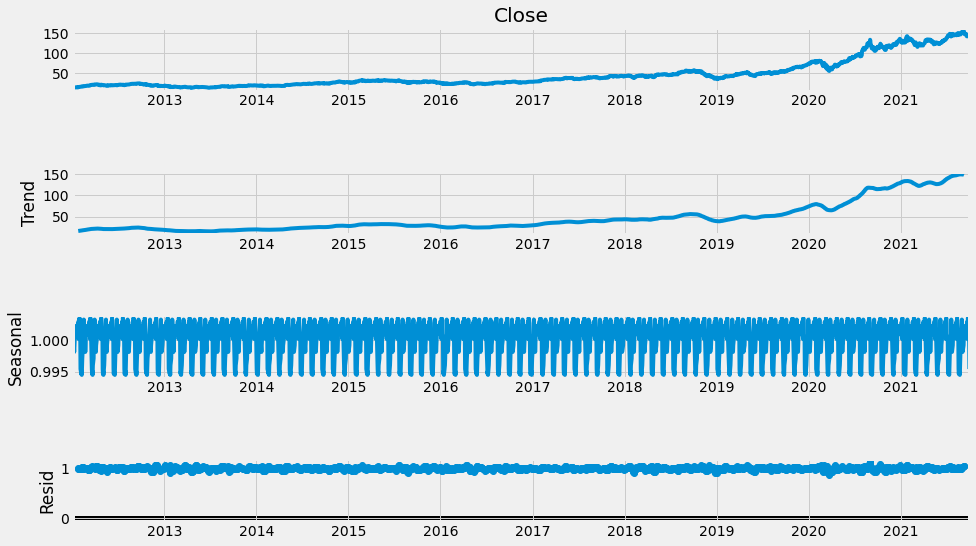

In [5]:
data=apple
data = data.set_index('Date')
df_close = data.Close
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

**Start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series.**


## AutoCorrelation and Partial AutoCorrelation

In [7]:
autocorrelation = acf(apple['Adj Close'], fft=True, nlags=40)
autocorrelation = np.array(autocorrelation)

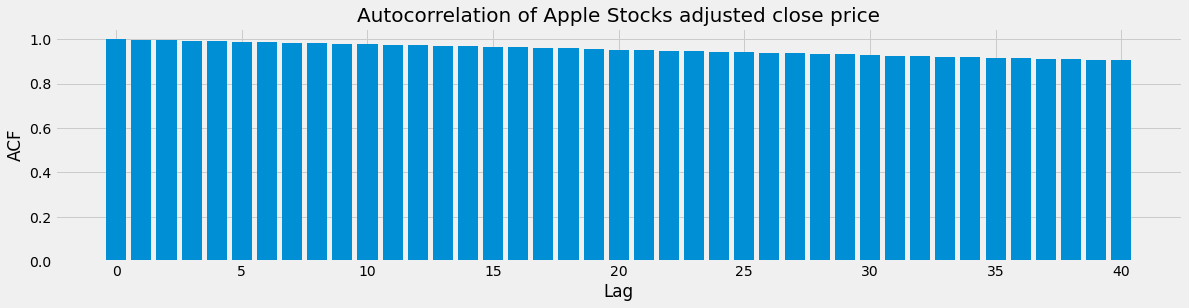

In [8]:
plt.figure(figsize=(18,4))
plt.title('Autocorrelation of Apple Stocks adjusted close price', fontsize=20, color='k')
plt.bar(range(len(autocorrelation)), autocorrelation)
plt.xlabel('Lag', color='k')
plt.ylabel('ACF', color='k')
plt.show()

Here we can see that the Autocorrelation decreases in a linear function as the lag increases. Hence the correlogram above indicates a clear trend!

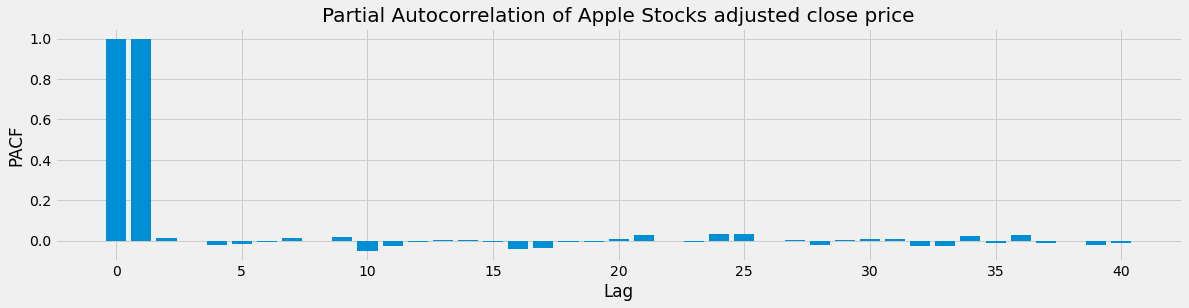

In [9]:
partial_autocorrelation = pacf(apple['Adj Close'], nlags=40)
partial_autocorrelation = np.array(partial_autocorrelation)

plt.figure(figsize=(18,4))
plt.title('Partial Autocorrelation of Apple Stocks adjusted close price', fontsize=20, color='k')
plt.bar(range(len(partial_autocorrelation)), partial_autocorrelation)
plt.xlabel('Lag', color='k')
plt.ylabel('PACF', color='k')
plt.show()

As we can observe from the correlogram above, we have a spike in the first lag!

**Moving Averages**

No handles with labels found to put in legend.


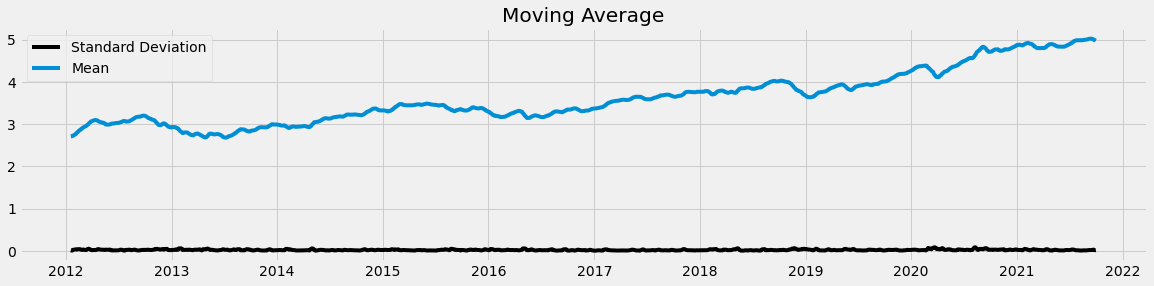

In [12]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 4
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, label = "Mean")
plt.legend()
plt.show()


## ARIMA
Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

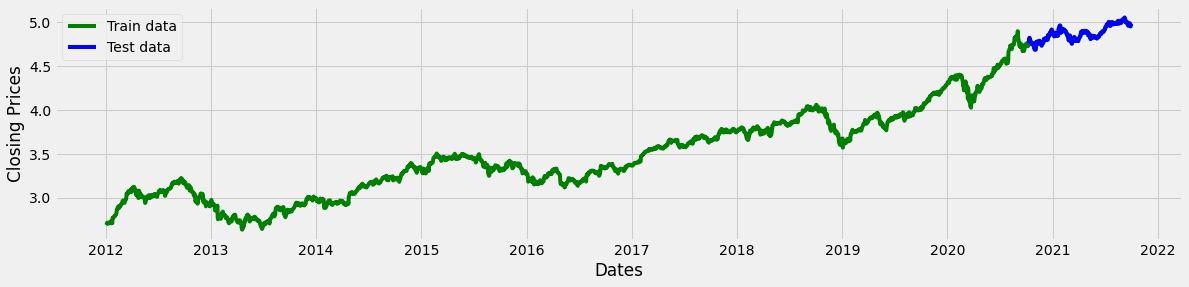

In [13]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(18, 4))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

**Auto ARIMA**: Automatically discover the optimal order for an ARIMA model.

The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model.

This function is based on the commonly-used R function, **forecast::auto.arima**.

The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, **d**, and then fitting models within ranges of defined **start_p**, **max_p**, **start_q**, **max_q ranges**.

If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [14]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11436.577, Time=3.89 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11443.415, Time=1.66 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11443.336, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11432.827, Time=0.97 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11441.440, Time=3.87 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11441.461, Time=1.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11439.430, Time=7.67 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-11438.905, Time=1.39 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 23.056 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2204
Model:               SARIMAX(1, 1, 0)   Log Likelihood                5724.707
Date:                Sun, 03 Oct 2021   AIC                         -11443.415
Time:              

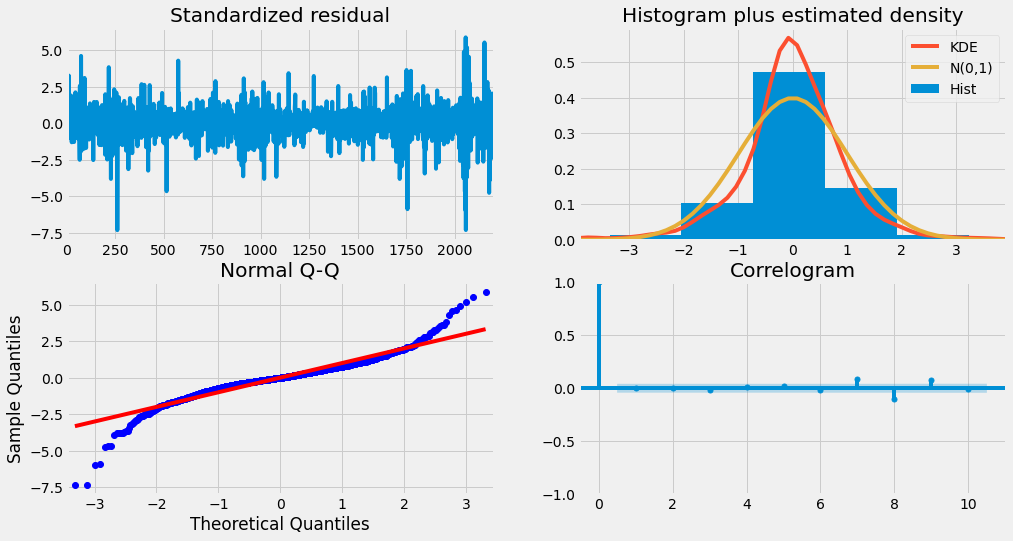

In [15]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?

**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right**: The density plot suggest normal distribution with mean zero.

**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s start forecasting the stock prices.

Next, create an ARIMA model with provided optimal parameters p, d and q.

In [16]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2203
Model:                 ARIMA(1, 1, 0)   Log Likelihood                5724.707
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 03 Oct 2021   AIC                         -11443.415
Time:                        01:27:08   BIC                         -11426.322
Sample:                             1   HQIC                        -11437.169
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.000      2.557      0.011       0.000       0.002
ar.L1.D.Close    -0.0633      0.021     -2.976      0.003      -0.105      -0.022
                                    Root

**Now let us forecast the stock prices on the test dataset keeping 95% confidence level.**

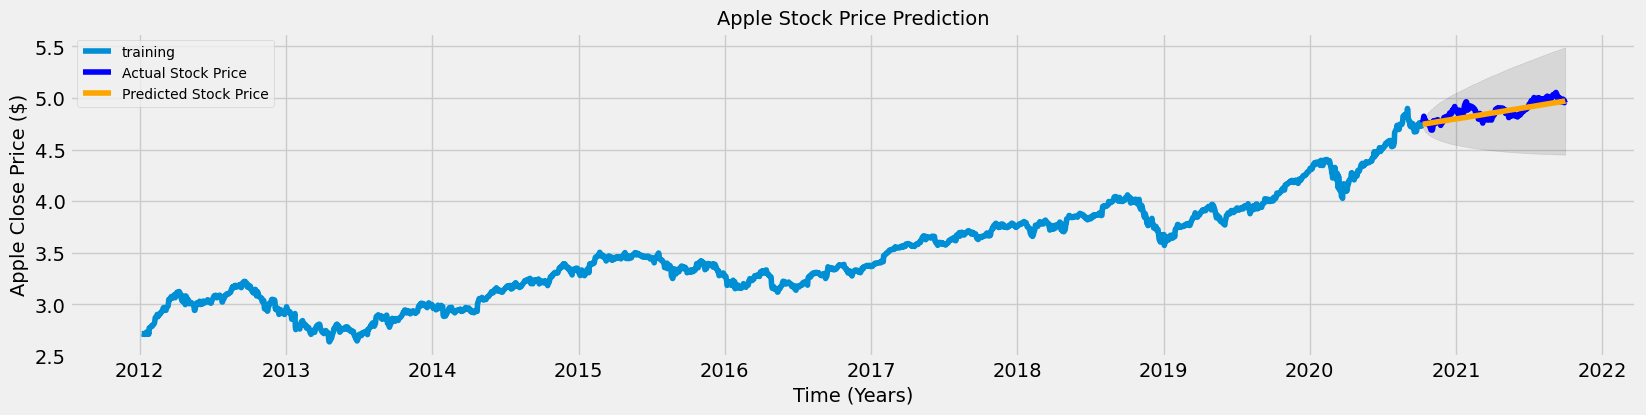

In [17]:
fc, se, conf = fitted.forecast(246, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(18,4), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction', fontsize=14)
plt.xlabel('Time (Years)', fontsize=14)
plt.ylabel('Apple Close Price ($)', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [18]:
import calendar
import time

time_now = time.ctime()
print(f'The time right now is {time_now} in Nairobi, Kenya!')
print('')

c = calendar.TextCalendar(calendar.SUNDAY)
c.prmonth(2021, 10)

The time right now is Sun Oct  3 01:28:24 2021 in Nairobi, Kenya!

    October 2021
Su Mo Tu We Th Fr Sa
                1  2
 3  4  5  6  7  8  9
10 11 12 13 14 15 16
17 18 19 20 21 22 23
24 25 26 27 28 29 30
31


Contact me for more explanations or questions or projects:

wltr.nathaniel@gmail.com